In [0]:
!pip install pymc3
!pip install arviz

     |████████████████████████████████| 1.3MB 6.6MB/s 
     |████████████████████████████████| 4.1MB 43.9MB/s 
     |████████████████████████████████| 307kB 44.3MB/s 


In [0]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn
import theano.tensor as tt

%matplotlib inline

```
wheel:
	reliability_index = 0.5*disk.nuts.hardness + 0.3*tire.elasticity + N (3, 0.2) (последний - качество сборки)
	tire:
		width: N(200, 15)
		diameter: N(630, 30)
		elasticity: N(10, 2)
	disk:
		width: N(190, 5) 
            # Пусть ширина диска должна быть ровно на 10мм меньше
diameter: N(430, 5)
 			# Пусть диаметр диска должен быть на 200мм меньше
		nuts:
			hardness: N(4, 0.3)
```



In [0]:
n_points = 10000
tire_width = np.random.normal(200, 15, n_points)
tire_diameter = np.random.normal(630, 30, n_points)
tire_elasticity = np.random.normal(10, 2, n_points)
disk_width = np.random.normal(190, 3, n_points)
disk_diameter = np.random.normal(430, 5, n_points)
nuts_hardness = np.random.normal(4, 0.3, n_points)
reliability_index = 0.5*nuts_hardness + 0.3*tire_elasticity + np.random.normal(3, 0.2, n_points)
def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))
defects_logits = 5 + abs(tire_width - disk_width - 10) / 15 + abs(tire_diameter - disk_diameter - 200) / 25 - nuts_hardness  - 0.5*reliability_index
defects_probs = sigmoid(defects_logits)
defects = [np.random.choice(2, p=[1-p, p]) for p in defects_probs]

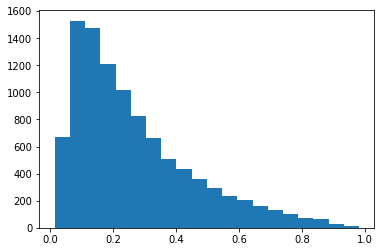

In [0]:
plt.hist(defects_probs, bins=20)
plt.show()

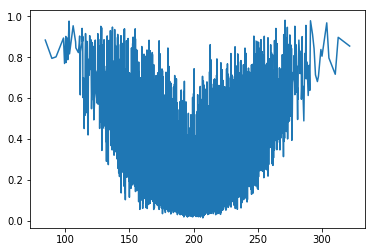

In [0]:
var = tire_diameter - disk_diameter
index = np.argsort(var)
plt.plot(var[index], defects_probs[index])

In [0]:
import pandas as pd
# reliability_index[np.random.choice(n_points, 100, replace=False)] = np.NAN
data = pd.DataFrame({'width_diff': abs(tire_width - disk_width - 10),
                     'diam_diff': abs(tire_diameter - disk_diameter - 200),
                     'tire_width': tire_width,
                     'disk_width': disk_width,
                     'tire_diameter': tire_diameter,
                     'disk_diameter': disk_diameter,
                     'nuts_hardness': nuts_hardness, 
                     'reliability_index': reliability_index, 
                     'defects': defects})

In [0]:
train_columns = ['nuts_hardness', 'reliability_index', 'width_diff', 'diam_diff'] #'tire_width', 'disk_width', 'tire_diameter', 'disk_diameter',
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.1, random_state = 42)

mask = np.array(np.random.rand(len(data_train), len(train_columns)) < .015, dtype=int)
X_train = np.ma.masked_array(data_train[train_columns], mask=mask)

### XGBoost

In [0]:
import xgboost as xgb

dtrain = xgb.DMatrix(data_train[train_columns], label = data_train['defects'])
dtest = xgb.DMatrix(data_test[train_columns], label = data_test['defects'])

param = {'max_depth': 2, 'eta': 0.3, 'objective': 'binary:logistic'}
param['nthread'] = 1
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 30
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.65949	train-auc:0.671237
[1]	eval-auc:0.707424	train-auc:0.720472
[2]	eval-auc:0.718243	train-auc:0.727092
[3]	eval-auc:0.727718	train-auc:0.7376
[4]	eval-auc:0.739596	train-auc:0.749707
[5]	eval-auc:0.743586	train-auc:0.753957
[6]	eval-auc:0.74384	train-auc:0.755438
[7]	eval-auc:0.743502	train-auc:0.7598
[8]	eval-auc:0.74863	train-auc:0.761896
[9]	eval-auc:0.753685	train-auc:0.764695
[10]	eval-auc:0.752322	train-auc:0.764623
[11]	eval-auc:0.74946	train-auc:0.765195
[12]	eval-auc:0.749897	train-auc:0.767333
[13]	eval-auc:0.749679	train-auc:0.768191
[14]	eval-auc:0.751236	train-auc:0.76892
[15]	eval-auc:0.749704	train-auc:0.769654
[16]	eval-auc:0.750321	train-auc:0.77025
[17]	eval-auc:0.751574	train-auc:0.77081
[18]	eval-auc:0.751748	train-auc:0.771698
[19]	eval-auc:0.752714	train-auc:0.772165
[20]	eval-auc:0.752179	train-auc:0.772526
[21]	eval-auc:0.752928	train-auc:0.773057
[22]	eval-auc:0.753284	train-auc:0.773368
[23]	eval-auc:0.754	train-auc:0.773701
[24]	eval-auc:0.

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[26]	eval-auc:0.752918	train-auc:0.77476
[27]	eval-auc:0.75324	train-auc:0.775251
[28]	eval-auc:0.753512	train-auc:0.775415
[29]	eval-auc:0.754157	train-auc:0.77642


In [0]:
ypred = bst.predict(dtest)

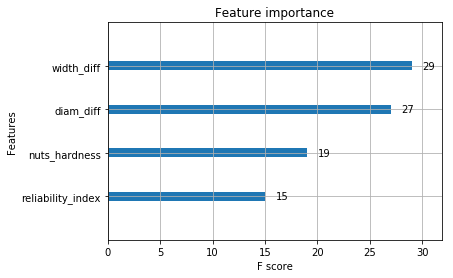

In [0]:
xgb.plot_importance(bst)

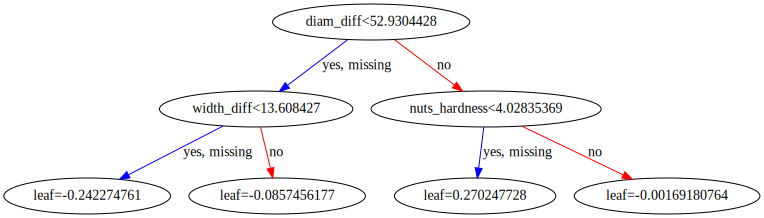

In [0]:
xgb.to_graphviz(bst, num_trees=2)

In [0]:
row = pd.DataFrame([{**{fn:np.nan for fn in train_columns}, 'nuts_hardness': 4.460573, 'disk_width': 190.265739, 'disk_diameter': 430, 'reliability_index': 8.34, 'width_diff': 10, 'diameter_diff': 200, 'tire_width': 200, 'tire_diameter': 630}])
bst.predict(xgb.DMatrix(row[train_columns]))

array([0.05783473], dtype=float32)

In [0]:
from sklearn.metrics import f1_score
f1_score(data_test['defects'], bst.predict(xgb.DMatrix(data_test[train_columns])) >= 0.5)

0.4263038548752835

### PyMC

In [0]:
def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

In [0]:
with pm.Model() as model:
    
#     pm.glm.GLM.from_formula('defects ~ nuts_hardness + reliability_index + width_diff + diam_diff',
#                             data_train,
#                             family=pm.glm.families.Binomial())
    Xmu = pm.Normal('Xmu', mu=0, sd=10, shape=(1,len(train_columns)))
    X_modeled = pm.Normal('X', mu=Xmu, sd=1., observed=X_train)

    intercept = pm.Normal('Intercept', 0, sd=20)
    coefs = [pm.Normal(colname, 0, sd=5) for colname in train_columns]
    
    y_prob = pm.math.sigmoid(intercept + sum([coefs[i] * X_modeled[:,i] for i in range(len(train_columns))]))
    y = pm.Bernoulli('y', y_prob, observed=data_train['defects'])
    trace = pm.sample(1000, tune=1000, chains=2, init='adapt_diag')

/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1331: UserWarning: Data in X contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUT

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1298577ac8>,
      dtype=object)

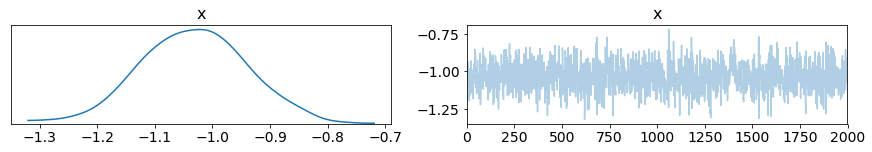

In [0]:
pm.traceplot(trace['nuts_hardness'], )
#                  X_missing=data_train[train_columns][mask==1]));

In [0]:
x_new = data_test[train_columns]
mask2 = np.array(np.random.rand(len(data_test), len(train_columns)) < .015, dtype=int)

with model:
    # Careful of the shape here. 
    # As the shape broadcasting might not work automatically
    X_mask = pm.Normal('X_mask3', mu=Xmu, sd=1., shape=(len(data_test), len(train_columns)))
    Xpred = tt.squeeze(X_mask)*mask2 + x_new*(1-mask2)
    
    y_prob2 = pm.math.sigmoid(intercept + sum([coefs[i] * Xpred[:,i] for i in range(len(train_columns))]))
    y2 = pm.Bernoulli('y3', y_prob2, shape=(len(data_test)))
    

100%|██████████| 300/300 [00:02<00:00, 109.43it/s]


In [0]:
ppc2 = pm.sample_posterior_predictive(trace, model=model, vars=[y2], samples=300)

100%|██████████| 300/300 [00:00<00:00, 488.06it/s]


In [0]:
probs, stds = ppc2['y3'].mean(axis=0), ppc2['y3'].std(axis=0)
f1_score(data_test['defects'], probs >= 0.5)

0.4336283185840708

In [0]:
mask_num = 6

In [109]:
row = pd.DataFrame([{'nuts_hardness': 2.460573,  'reliability_index': 8.34, 'width_diff': 10, 'diam_diff': 0}])
def predict_for_row(row):
    if isinstance(row, pd.DataFrame):
        row = row.iloc[0]
    vals = np.array([row[train_columns].tolist()]*(len(train_columns)+1))
    print(vals)
    masks = np.triu(np.ones((len(train_columns)+1, len(train_columns))))
    return predict_with_masks(vals, masks)

def predict_with_masks(vals, masks):
    global mask_num
    with model:
        X_mask = pm.Normal(f'X_mask{mask_num}', mu=Xmu, sd=1., shape=vals.shape)
        Xpred = tt.squeeze(X_mask)*masks + vals*(1-masks)
        y_prob = pm.math.sigmoid(intercept + sum([coefs[i] * Xpred[:,i] for i in range(len(train_columns))]))
        y = pm.Bernoulli(f'y{mask_num}', y_prob, shape=(len(vals)))
        mask_num += 1
        ppc = pm.sample_posterior_predictive(trace, model=model, vars=[y], samples=300)        
    return ppc[f'y{mask_num-1}']

%time ppc3 = predict_for_row(row)

[[ 2.460573  8.34     10.        0.      ]
 [ 2.460573  8.34     10.        0.      ]
 [ 2.460573  8.34     10.        0.      ]
 [ 2.460573  8.34     10.        0.      ]
 [ 2.460573  8.34     10.        0.      ]]


100%|██████████| 300/300 [00:00<00:00, 539.05it/s]

CPU times: user 800 ms, sys: 27.2 ms, total: 827 ms
Wall time: 813 ms


In [0]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.pointplot(x="time", y="total_bill", data=tips)

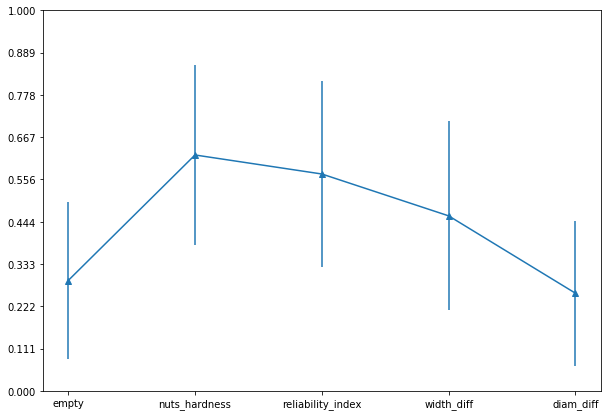

In [110]:
plt.figure(figsize=(10,7))
plt.errorbar(np.arange(5), ppc3.mean(axis=0), ppc3.std(axis=0)**2, marker='^')
plt.xticks(np.arange(5), ['empty'] + train_columns)
plt.yticks(np.linspace(0, 1, 10))
plt.show()

In [0]:
X_test = data_test.iloc[0]
X_input.set_value(X_test)
ppc = pm.sample_posterior_predictive(trace, model=logistic_model, samples=300)

100%|██████████| 300/300 [00:01<00:00, 187.26it/s]


In [0]:
ppc['y'].mean(), data_train['defects'].value_counts(normalize=True)[1]

(0.26977814814814816, 0.26966666666666667)

<Figure size 648x504 with 0 Axes>

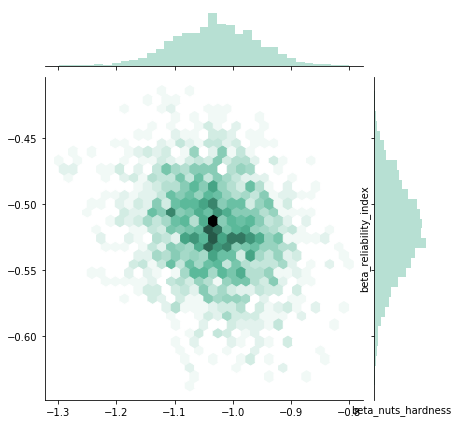

In [0]:
plt.figure(figsize=(9,7))
seaborn.jointplot(trace['nuts_hardness'], trace['reliability_index'], kind="hex", color="#4CB391")
plt.xlabel("beta_nuts_hardness")
plt.ylabel("beta_reliability_index");

In [0]:
def lm_full(trace, nuts_hardness, reliability_index):
    shape = np.broadcast(nuts_hardness, reliability_index).shape
    x_norm = np.asarray([np.broadcast_to(x, shape)
                         for x in [nuts_hardness, reliability_index]])
    return 1 / (1 + np.exp(-(trace['Intercept'] +
                             trace['nuts_hardness']*x_norm[0] +
                             trace['reliability_index']*x_norm[1]
                            )))

# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: lm_full(samples, x, 6.)

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: lm_full(samples, x, 8.)

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: lm_full(samples, x, 9.)

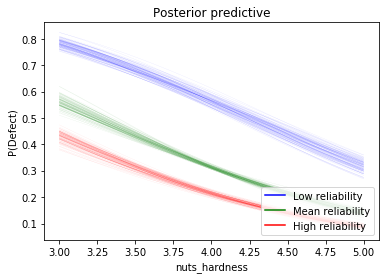

In [0]:
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    3, 5, 1000), lm=lm, samples=100, color="blue", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    3, 5, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(
    3, 5, 1000), lm=lm3, samples=100, color="red", alpha=.15)

import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='Low reliability')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Mean reliability')
red_line = mlines.Line2D(['lm3'], [], color='r', label='High reliability')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Defect)")
plt.xlabel("nuts_hardness")
plt.show()

In [0]:
lb, ub = np.percentile(trace['reliability_index'], 2.5), np.percentile(trace['reliability_index'], 97.5)

print("P(%.3f < Reliability < %.3f) = 0.95" % (lb,ub))


P(-0.594 < Reliability < -0.452) = 0.95


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rf = RandomForestClassifier(n_estimators=10, )
rf.fit(data_train[train_columns], data_train['defects'])


ValueError: ignored

In [0]:
!pip install pymc-learn

In [0]:
import pmlearn
from pmlearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
data_scaled = data.copy()
# data_scaled[train_columns] = scale(data_scaled[train_columns])

In [0]:
import theano
floatX = theano.config.floatX
X = data_scaled[train_columns].astype(floatX)
y = data_scaled['defects'].astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [0]:
model = LogisticRegression()

In [0]:
model.fit(X_train, y_train, [0]*len(y_train), inference_type='nuts')

Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]
100%|██████████| 2500/2500 [07:44<00:00,  5.90it/s]
The acceptance probability does not match the target. It is 0.8911564227913268, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8988940431052731, but should be close to 0.8. Try to increase the number of tuning steps.


LogisticRegression()

In [0]:
X_train['reliability_index'].mean()

7.993975543552357

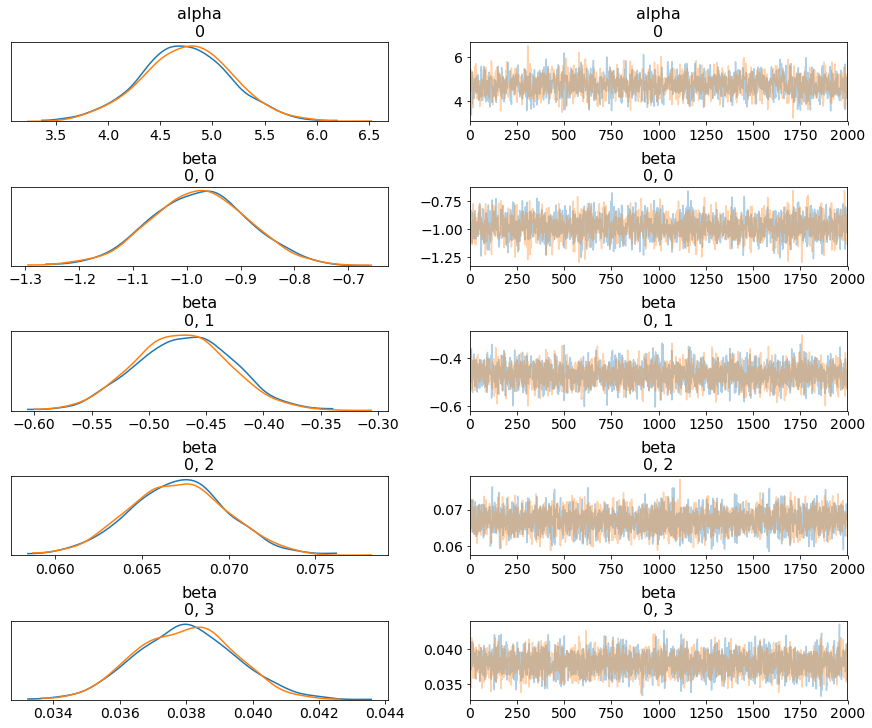

In [0]:
pm.traceplot(model.trace)
plt.show()

In [0]:
y_prob = model.predict_proba(X_test, [0]*len(X_test))


100%|██████████| 2000/2000 [00:25<00:00, 77.21it/s]


In [0]:
f1_score(y_test, y_prob >= 0.5)

0.4444444444444444

In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_prob)

0.7689296973598827

In [0]:
row = pd.DataFrame([{**{fn:np.nan for fn in train_columns}, 'nuts_hardness': 4.60573, 'reliability_index': np.nan, 'width_diff': 25, 'diam_diff': 40}]) # 'disk_width': 190.265739, 'disk_diameter': 430, , 'tire_width': 200, 'tire_diameter': 630
# for col in row.columns:
#     if pd.isna(row.iloc[0][col]):
#         row[col] = X_train[col].mean()
# row

In [0]:
model.predict_proba(row[train_columns], [0], return_std=True)